In [1]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

import crocosi.postp as pp
import dask.dataframe as dd
import pandas as pd

import hvplot.pandas
import hvplot.dask
import pandas as pd
from glob import glob

In [2]:
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client

Client Scheduler: tcp://127.0.0.1:54804 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [67]:
#from u grid to rho grid:

def u2rho(var_u,intert):


    if var_u.ndim<3:
        var_rho = u2rho_2d(var_u)
    else:
        var_rho = u2rho_3d(var_u,intert)

    return var_rho


def u2rho_2d(var_u):

    [Mp,L]=var_u.shape
    Lp=L+1
    Lm=L-1
    var_rho=xr.Dataset({'u': (['y_rho','x_rho'],np.zeros((Mp,Lp)))},coords={'y_rho' : r['surf'].ssh.coords['y_rho'].values,
                                                                          'x_rho' : r['surf'].ssh.coords['x_rho'].values})

#r['surf'].ssh.sel(time=1550,method='nearest').copy()#np.zeros((Mp,Lp))
    var_rho.u[:,1:L]=0.5*(var_u[:,0:Lm]+var_u[:,1:L])
    var_rho.u[:,0]=var_rho.u[:,1]
    var_rho.u[:,Lp-1]=var_rho.u[:,L-1]
    return var_rho


def u2rho_3d(var_u,intert):

    [N,Mp,L]=var_u.shape
    Lp=L+1
    Lm=L-1
    var_rho=xr.Dataset({'u': (['time','y_rho','x_rho'],np.zeros((N,Mp,Lp)))},coords={'time' : r['surf'].ssh.sel(time=slice(intert[0],intert[1])).coords['time'].values,
                                                                              'y_rho' : r['surf'].ssh.coords['y_rho'].values,
                                                                          'x_rho' : r['surf'].ssh.coords['x_rho'].values})

    #r['surf'].ssh.sel(time=1550,method='nearest').copy()#np.zeros((Mp,Lp))
    var_rho.u[:,:,1:L]=0.5*(var_u[:,:,0:Lm]+var_u[:,:,1:L])
    var_rho.u[:,:,0]=var_rho.u[:,:,1]
    var_rho.u[:,:,Lp-1]=var_rho.u[:,:,L-1]
    return var_rho

#######################################################

#From v grid to rho grid:

def v2rho(var_v):

    if var_v.ndim<3:
        var_rho = v2rho_2d(var_v)
    else:
        var_rho = v2rho_3d(var_v)

    return var_rho


def v2rho_2d(var_v):

    [M,Lp]=var_v.shape
    Mp=M+1
    Mm=M-1
    var_rho=xr.Dataset({'v': (['time','y_rho','x_rho'],np.zeros((Mp,Lp)))},coords={'time' : r['surf'].ssh.coords['time'].values,
                                                                            'y_rho' : r['surf'].ssh.coords['y_rho'].values,
                                                                          'x_rho' : r['surf'].ssh.coords['x_rho'].values})

    var_rho.v[1:M,:]=0.5*(var_v[0:Mm,:]+var_v[1:M,:])
    var_rho.v[0,:]=var_rho.v[1,:]
    var_rho.v[Mp-1,:]=var_rho.v[M-1,:]
    return var_rho



def v2rho_3d(var_v):

    [N,M,Lp]=var_v.shape
    Mp=M+1
    Mm=M-1
    var_rho=xr.Dataset({'v': (['y_rho','x_rho'],np.zeros((N,Mp,Lp)))},coords={'y_rho' : r['surf'].ssh.coords['y_rho'].values,
                                                                            'x_rho' : r['surf'].ssh.coords['x_rho'].values})

    var_rho.v[:,1:M,:]=0.5*(var_v[:,0:Mm,:]+var_v[:,1:M,:])
    var_rho.v[:,0,:]=var_rho.v[:,1,:]
    var_rho.v[:,Mp-1,:]=var_rho.v[:,M-1,:]

    return var_rho

In [3]:
root_path = '/Users/zcaspar/'
#run = 'jet_cfg1_wp9_4km_0a2000j/'
run = 'jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/'
#file='t1/file_his_00010101-00010125.nc'
#File='t1'
gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.CROCOrun(root_path+run, prefix='file_', open_nc=['surf'], grid_params=gparams)

In [7]:
u_rho = u2rho(r['surf'].u[:,0,:,:])

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:54958 remote=tcp://127.0.0.1:54804>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:54959 remote=tcp://127.0.0.1:54804>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:54960 remote=tcp://127.0.0.1:54804>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:54961 remote=tcp://127.0.0.1:54804>


Traceback (most recent call last):
  File "/opt/anaconda3/envs/croco/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-1628538cae21>", line 1, in <module>
    u_rho = u2rho(r['surf'].u[:,0,:,:])
  File "<ipython-input-6-91c60a3f651b>", line 9, in u2rho
    var_rho = u2rho_3d(var_u)
  File "<ipython-input-6-91c60a3f651b>", line 32, in u2rho_3d
    var_rho[:,:,1:L]=0.5*(var_u[:,:,0:Lm]+var_u[:,:,1:L])
  File "/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/dataarray.py", line 2512, in func
    coords, indexes = self.coords._merge_raw(other_coords)
  File "/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/coordinates.py", line 126, in _merge_raw
    variables, indexes = merge_coordinates_without_align([self, other])
  File "/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/merge.py", line 317, in merge_coordinates_without_alig

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [64]:
var_u = r['surf'].u[:,0,:,:].sel(time=slice(1550,1552))

In [46]:
import xarray as xr

In [57]:
[Mp,L]=var_u.shape
Lp=L+1
Lm=L-1
var_rho=xr.Dataset({'u': (['y_rho','x_rho'],np.zeros((Mp,Lp)))},coords={'y_rho' : r['surf'].ssh.coords['y_rho'].values,
                                                                      'x_rho' : r['surf'].ssh.coords['x_rho'].values})

#r['surf'].ssh.sel(time=1550,method='nearest').copy()#np.zeros((Mp,Lp))
var_rho.u[:,1:L]=0.5*(var_u[:,0:Lm]+var_u[:,1:L])
var_rho.u[:,0]=var_rho.u[:,1]
var_rho.u[:,Lp-1]=var_rho.u[:,L-1]

In [58]:
var_rho.u.shape

(722, 258)

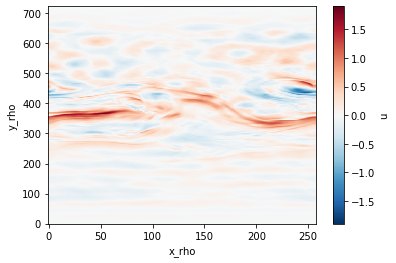

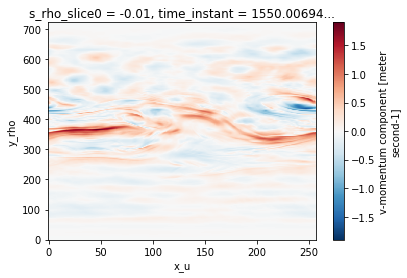

In [59]:
var_rho.u.plot()
plt.figure()
var_u.plot()

In [38]:
r['surf'].ssh

<xarray.DataArray 'ssh' (time: 14400, y_rho: 722, x_rho: 258)>
dask.array<concatenate, shape=(14400, 722, 258), dtype=float32, chunksize=(1, 722, 258), chunktype=numpy.ndarray>
Coordinates:
    eta_rho       (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    xi_rho        (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    time_instant  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time          (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 1.6e+03 1.6e+03
    f             (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
Dimensions without coordinates: y_rho, x_rho
Attributes:
    long_name:           free-surface
    units:               meter
    online_operation:    instant
    interval_operation:  300 s
    interval_write:      600 s
    cell_methods:        time: point (interval: 300 s)

In [25]:
0var_u.sel(time=1550,method='nearest')+var_u.sel(time=1550,method='nearest').roll(x_u=1)

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/dataarray.py:2727: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


<xarray.DataArray 'u' (y_rho: 722, x_u: 257)>
dask.array<add, shape=(722, 257), dtype=float32, chunksize=(722, 257), chunktype=numpy.ndarray>
Coordinates:
    eta_u         (y_rho, x_u) float32 -2000.0 -2000.0 ... 2882000.0 2882000.0
    s_rho_slice0  float32 -0.01
    time          float64 1.55e+03
Dimensions without coordinates: y_rho, x_u

In [26]:
0.5*(var_u.sel(time=1550,method='nearest')[:,0:-1]+var_u.sel(time=1550,method='nearest')[:,1:])

<xarray.DataArray 'u' (y_rho: 722, x_u: 256)>
dask.array<mul, shape=(722, 256), dtype=float32, chunksize=(722, 256), chunktype=numpy.ndarray>
Coordinates:
    eta_u         (y_rho, x_u) float32 -2000.0 -2000.0 ... 2882000.0 2882000.0
    s_rho_slice0  float32 -0.01
    time          float64 1.55e+03
Dimensions without coordinates: y_rho, x_u

In [39]:
var_rho.values

array([[ 0.5857827 ,  0.5857856 ,  0.5858084 , ...,  0.5857729 ,
         0.5857827 ,  0.5857856 ],
       [ 0.5857671 ,  0.58577067,  0.58579385, ...,  0.5857567 ,
         0.5857671 ,  0.58577067],
       [ 0.58534026,  0.5853355 ,  0.58534384, ...,  0.585338  ,
         0.58534026,  0.5853355 ],
       ...,
       [-0.58516496, -0.58509755, -0.58512324, ..., -0.5854088 ,
        -0.58516496, -0.58509755],
       [-0.5848024 , -0.5849551 , -0.5850639 , ..., -0.58492416,
        -0.5848024 , -0.5849551 ],
       [-0.5848211 , -0.584975  , -0.58508414, ..., -0.58494055,
        -0.5848211 , -0.584975  ]], dtype=float32)

In [ ]:
var_u = r['surf'].u[:,0,:,:]
test = u2rho(var_u,[1500,1600])
%time

In [66]:
r['surf'].ssh.coords['time']

<xarray.DataArray 'time' (time: 14400)>
array([1500.003472, 1500.010417, 1500.017361, ..., 1599.982639, 1599.989583,
       1599.996528])
Coordinates:
    time_instant  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time          (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 1.6e+03 1.6e+03

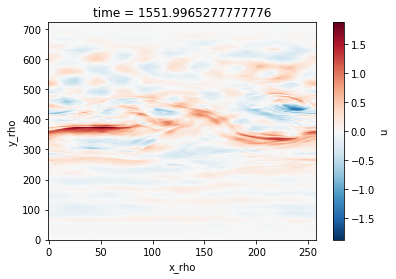

In [73]:
test.u.sel(time=1552,method='nearest').plot()